# Model Seq2Seq
attention based model
text -> Model -> new text

In [1]:
import tensorflow
import os
import pandas as pd
import yaml
from dataset import DataLoader
from dataset import DataPreprocessing
from dataset import TokenizerWrap
from model import AutoEncoderModel

In [2]:
def config_loader(filepath):
    with open (filepath, 'r') as file_descriptor:
        config = yaml.safe_load(file_descriptor)
    return config

In [3]:
config = config_loader('config/en_de.yaml')

In [4]:
lang_src, lang_dest = config['language']['src'],config['language']['dest'] 

In [5]:
modelConfig_autoencoder = config_loader('config/autoencoder.yaml')

In [6]:
config

{'language': {'src': 'en', 'dest': 'de'},
 'dataset_path': '/europarl-v7.de-en.'}

In [7]:
lang_src

'en'

In [8]:
lang_dest

'de'

In [9]:
data_loader = DataLoader(config)

In [10]:
path = 'training'
os.listdir(path)

['europarl-v7.cs-en.cs',
 'europarl-v7.cs-en.en',
 'europarl-v7.de-en.de',
 'europarl-v7.de-en.en',
 'europarl-v7.es-en.en',
 'europarl-v7.es-en.es',
 'europarl-v7.fr-en.en',
 'europarl-v7.fr-en.fr',
 'questions_easy.csv']

In [11]:
src, dest = data_loader.loadData(path)

Loaded dataset at directory:
training/europarl-v7.de-en.en


In [12]:
type(src)

list

In [13]:
src[1]

'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.'

In [14]:
dest[1]

'Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.'

In [15]:
data_preprocessing = DataPreprocessing(config)

In [16]:
src = data_preprocessing.addStartEndPad(src)

In [17]:
src[0]

'aaaa Resumption of the session oooo'

In [18]:
df = data_preprocessing.createDataFrameSrcDest(src,dest)

In [19]:
df.head()

,en,de
0,aaaa Resumption of the session oooo,Wiederaufnahme der Sitzungsperiode
1,aaaa I declare resumed the session of the Euro...,"Ich erkläre die am Freitag, dem 17. Dezember u..."
2,"aaaa Although, as you will have seen, the drea...","Wie Sie feststellen konnten, ist der gefürchte..."
3,aaaa You have requested a debate on this subje...,Im Parlament besteht der Wunsch nach einer Aus...
4,"aaaa In the meantime, I should like to observe...",Heute möchte ich Sie bitten - das ist auch der...


In [20]:
df = df[:100000]

# Preprocessing

In [21]:
df.dtypes

en    object
de    object
dtype: object

In [22]:
df = df.astype(str)

In [23]:
df = data_preprocessing.toLowerCase(df)

In [24]:
df.head()

,en,de
0,aaaa resumption of the session oooo,wiederaufnahme der sitzungsperiode
1,aaaa i declare resumed the session of the euro...,"ich erkläre die am freitag, dem 17. dezember u..."
2,"aaaa although, as you will have seen, the drea...","wie sie feststellen konnten, ist der gefürchte..."
3,aaaa you have requested a debate on this subje...,im parlament besteht der wunsch nach einer aus...
4,"aaaa in the meantime, i should like to observe...",heute möchte ich sie bitten - das ist auch der...


In [25]:
from tqdm.notebook import tqdm

In [26]:
import numpy as np

In [27]:
num_words =10000
tokenizer_src = TokenizerWrap(texts=df[lang_src],
                              padding='pre',
                              reverse=True,
                              num_words=num_words)

In [28]:
tokenizer_dest = TokenizerWrap(texts=df[lang_dest],
                               padding='post',
                               reverse=False,
                               num_words=num_words)

In [29]:
tokens_src = tokenizer_src.tokens_padded
tokens_dest = tokenizer_dest.tokens_padded
print(tokens_src.shape)
print(tokens_dest.shape)

(100000, 57)
(100000, 48)


In [30]:
tokens_src[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    3,  926,    1,    4,
       5176,    2])

In [31]:
token_end = tokenizer_dest.word_index['weshalb']
token_end

978

In [32]:
idx = 2

In [33]:
tokens_src[idx]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    3, 4987,  106, 1610,   10, 1823,
        954,    4, 1450,    9, 2139,   68,    4,  207,    9,    7,   82,
          1,  180, 7944,    5, 1710,    1,  639,   22,   26,   44,   20,
        362,    2])

In [34]:
tokenizer_src.tokens_to_string(tokens_src[idx])

'oooo dreadful were truly that disasters natural of series a suffered countries of number a in people the still materialise to failed the seen have will you as although aaaa'

In [35]:
df[lang_src][idx]

"aaaa although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful. oooo"

In [36]:
encoder_input_data = tokens_src
decoder_input_data = tokens_dest[:, :-1]
decoder_output_data = tokens_dest[:, 1:]
decoder_output_data.shape

(100000, 47)

In [37]:
tokens_dest[idx]

array([  30,   23,  755, 1034,   12,    2,   14, 4648,  100,   28,  150,
        923,  123,   76,  634,   10, 4326, 4250,  955,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [38]:
tokenizer_dest.tokens_to_string(tokens_dest[idx])

'wie sie feststellen konnten ist der nicht eingetreten doch sind bürger einiger unserer mitgliedstaaten opfer von schrecklichen naturkatastrophen geworden'

In [39]:
df[lang_dest][idx]


'wie sie feststellen konnten, ist der gefürchtete "millenium-bug " nicht eingetreten. doch sind bürger einiger unserer mitgliedstaaten opfer von schrecklichen naturkatastrophen geworden.'

In [40]:
from tensorflow.keras.layers import *

In [41]:

autoEncoder = AutoEncoderModel(modelConfig_autoencoder)
model_train = autoEncoder.BuildModel()

In [42]:
encoder_output, encoder_model = autoEncoder.encoderModel()
decoder_output, decoder_model = autoEncoder.decoderModel(encoder_output,alone=True)
        

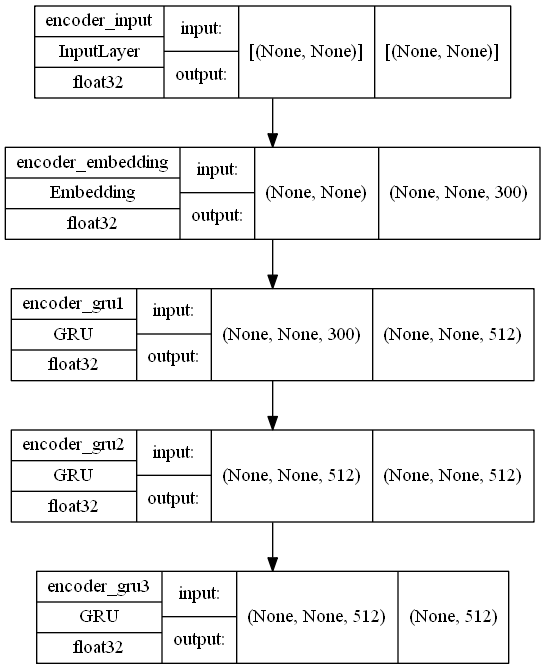

In [43]:
import tensorflow as tf
tf.keras.utils.plot_model(
    encoder_model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)

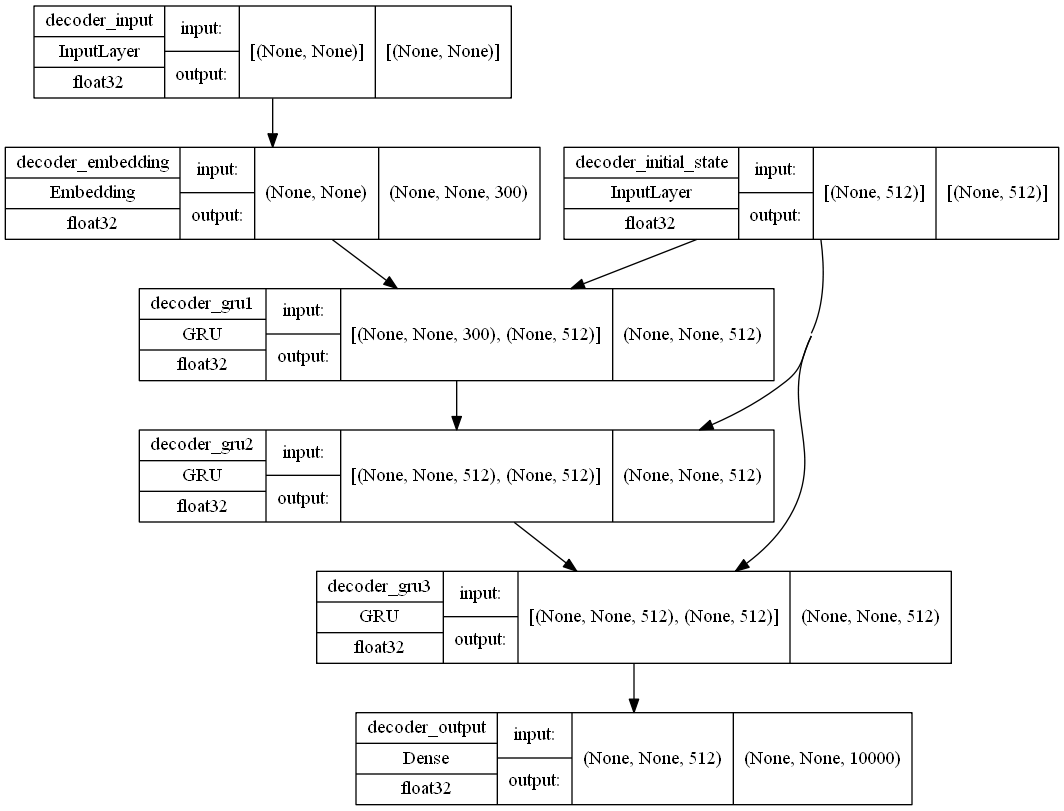

In [44]:

tf.keras.utils.plot_model(
    decoder_model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)


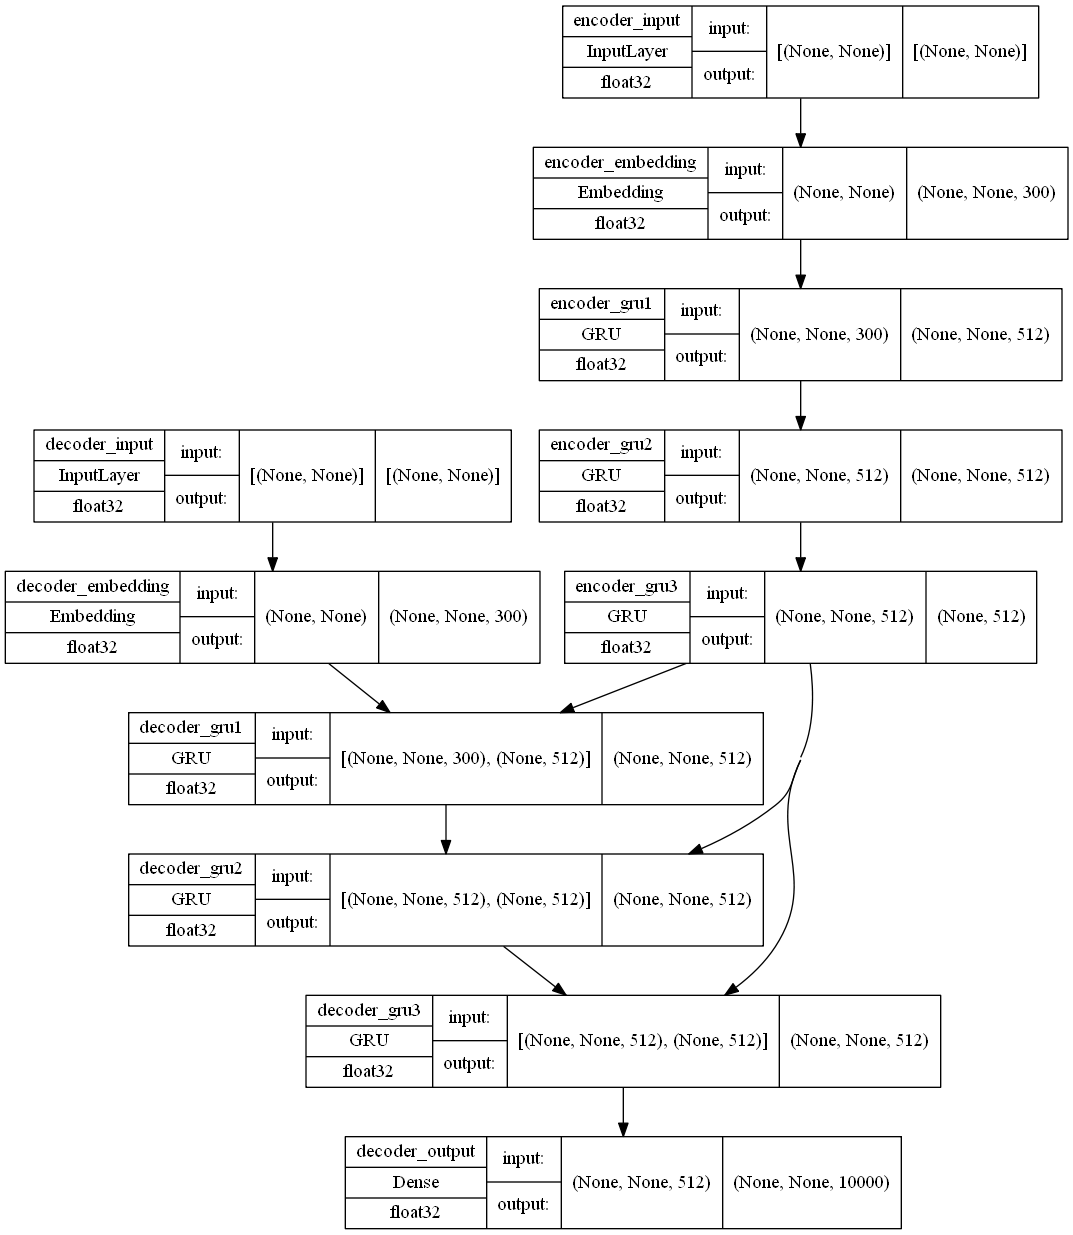

In [45]:
tf.keras.utils.plot_model(
    model_train,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)

In [46]:

callbacks = autoEncoder.getCallbacks()


In [47]:

try:
    model_train.load_weights(modelConfig_autoencoder['callbacks']['ModelCheckPoint']['filepath'])
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [48]:
x_data = \
{
    'encoder_input': encoder_input_data,
    'decoder_input': decoder_input_data
}

In [49]:
y_data = \
{
    'decoder_output': decoder_output_data
}

In [50]:
validation_split = 10000 / len(encoder_input_data)
validation_split

0.1

In [51]:
model_train.fit(x=x_data,
                y=y_data,
                batch_size=128,
                epochs=1000,
                validation_split=validation_split,
                callbacks=callbacks)

Epoch 1/1000
703/704 [============================>.] - ETA: 0s - loss: 1.9295
Epoch 1: val_loss improved from inf to 2.25209, saving model to CheckPoint
704/704 [==============================] - 154s 209ms/step - loss: 1.9297 - val_loss: 2.2521
Epoch 2/1000
703/704 [============================>.] - ETA: 0s - loss: 1.8743
Epoch 2: val_loss improved from 2.25209 to 2.21382, saving model to CheckPoint
704/704 [==============================] - 147s 209ms/step - loss: 1.8742 - val_loss: 2.2138
Epoch 3/1000
703/704 [============================>.] - ETA: 0s - loss: 1.8223
Epoch 3: val_loss improved from 2.21382 to 2.20717, saving model to CheckPoint
704/704 [==============================] - 147s 209ms/step - loss: 1.8223 - val_loss: 2.2072
Epoch 4/1000
 44/704 [>.............................] - ETA: 2:13 - loss: 1.7237

KeyboardInterrupt: 

In [52]:
mark_end = ' oooo'
token_start = tokenizer_src.word_index[mark_end.strip()]
token_start

3

In [53]:
def translate(input_text, true_output_text=None):
    """Translate a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                reverse=True,
                                                padding=True)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state = encoder_model.predict(input_tokens)

    # Max number of tokens / words in the output sequence.
    max_tokens = tokenizer_dest.max_tokens

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    
    decoder_input_data = np.zeros(shape=shape, dtype=int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'decoder_initial_state': initial_state,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.

        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0, count_tokens, :]
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    
    # Print the input-text.
    print("Input text:")
    print(input_text)
    print()

    # Print the translated output-text.
    print("Translated text:")
    print(output_text)
    print()

    # Optionally print the true translated text.
    if true_output_text is not None:
        print("True output text:")
        print(true_output_text)
        print()

In [54]:
idx = 3
translate(input_text=df[lang_src][idx],
          true_output_text=df[lang_dest][idx])

Input text:
aaaa you have requested a debate on this subject in the course of the next few days, during this part-session. oooo

Translated text:
 frau kommissarin liebe kolleginnen und kollegen es ist ein problem das wir heute behandeln müssen                                                                  

True output text:
im parlament besteht der wunsch nach einer aussprache im verlauf dieser sitzungsperiode in den nächsten tagen.



In [55]:
idx = 90
translate(input_text=df[lang_src][idx],
          true_output_text=df[lang_dest][idx])

Input text:
aaaa mr hänsch represented you on this occasion. oooo

Translated text:
 das ist ein problem                                                                                        

True output text:
der kollege hänsch hat sie dort vertreten.



In [56]:
translate(input_text="I want to join the European Union",
          true_output_text=None)

Input text:
I want to join the European Union

Translated text:
 das europäische parlament hat sich nicht auf die frage der menschenrechte                                                                          



In [ ]:
model_train